In [21]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
import numpy as np
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score
import gc

In [22]:
from matplotlib import pylab as plt
%matplotlib inline

def plot_accuracy(alphas, filename, yt, Test_tf_idf):
    results = {i:0 for i in alphas}
    for alpha in results.keys():
        clf = pd.read_pickle(filename.format(alpha))
        results[alpha] = accuracy_score(yt, clf.predict(Test_tf_idf))
    fig, ax = plt.subplots()
    fig.set_figwidth(20)
    fig.set_figheight(12)
    plt.plot([str(i) for i in results.keys()],  results.values(), markersize = 10, marker = 'o', color = 'blue')
    ax.set_xlabel('C', fontsize = 20, )
    ax.set_ylabel('accuracy_score', fontsize = 20)
    plt.xticks(rotation=90)
    ax.grid();

In [3]:
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')

In [4]:
Train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [5]:
Test.head()

,title,description,itemid
0,Мастерка,Мастерка фирмы форвард. Белого цвета. В идеаль...,1778449823
1,Зимние сапоги,"Продаю зимние сапоги, в хорошем состоянии, все...",1677656962
2,Видеонаблюдение 8 камер,В комплект Atis AMD-2MIR-8kit входит: /\n1. Ку...,1758182804
3,Запчасти для GLE,Запчасти GLE,1689811299
4,Бластер nerf,Состояние 5+/\nПродаю потому что не нужен/\n18...,1804706240


In [6]:
Train.isnull().sum()

title            0
description      2
Category_name    0
Category         0
dtype: int64

In [7]:
Test.isnull().sum()

title          0
description    1
itemid         0
dtype: int64

In [8]:
Train.fillna('', inplace=True)
Test.fillna('', inplace=True)

In [9]:
Train['title&description'] = Train['title'].str[:] + ' ' + Train['description'].str[:]
Test['title&description'] = Test['title'].str[:] + ' ' + Test['description'].str[:]
Train['title&description'] = Train['title&description'].str.lower()
Test['title&description'] = Test['title&description'].str.lower()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Train[['title&description']][:200000], Train['Category'][:200000])

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train['title&description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
gc.collect()

In [15]:
X_train_tf_idf = tf_idf.transform(X_train['title&description'])
X_test_tf_idf = tf_idf.transform(X_test['title&description'])

In [16]:
from sklearn.metrics import accuracy_score

# на самом деле считал для большего количества параметров,
# но оптимальный параметр 11.125 нашелся в этом промежутке
for i in np.linspace(8, 12, 10):
    clf = LogisticRegression(C=i, solver='sag', max_iter=500, n_jobs=64)
    st = time.time()
    clf.fit(X_train_tf_idf, y_train)
    pd.to_pickle((clf), 'clf_logr_{}'.format(i))
    print(time.time() - st, accuracy_score(y_test, clf.predict(X_test_tf_idf)))

/home/ubuntu/python-virtual-environments/p3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


38.371556520462036 0.88144
40.0061936378479 0.88144
37.49946308135986 0.88158
38.879403591156006 0.88164
41.81058597564697 0.88184
45.2216215133667 0.88194
48.46400046348572 0.88192
46.2189826965332 0.88194
49.16834211349487 0.88188
50.455615758895874 0.882


In [ ]:
# def plot_rmse(alphas):
#     results = {i:0 for i in alphas}
#     for alpha in results.keys():
#         clf = pd.read_pickle('clf_logrv3_{}.pkl'.format(alpha))
#         results[alpha] = accuracy_score(y_test, clf.predict(X_test_tf_idf))

#     fig, ax = plt.subplots()
#     fig.set_figwidth(20)
#     fig.set_figheight(12)
#     i = 0
#     plt.plot([str(i) for i in results.keys()],  results.values(), markersize = 10, marker = 'o', color = colors[i], label=alpha)
#     i += 1
#     ax.set_xlabel('C', fontsize = 20, )
#     ax.set_ylabel('accuracy_score', fontsize = 20)
#     plt.xticks(rotation=90)
#     ax.grid()

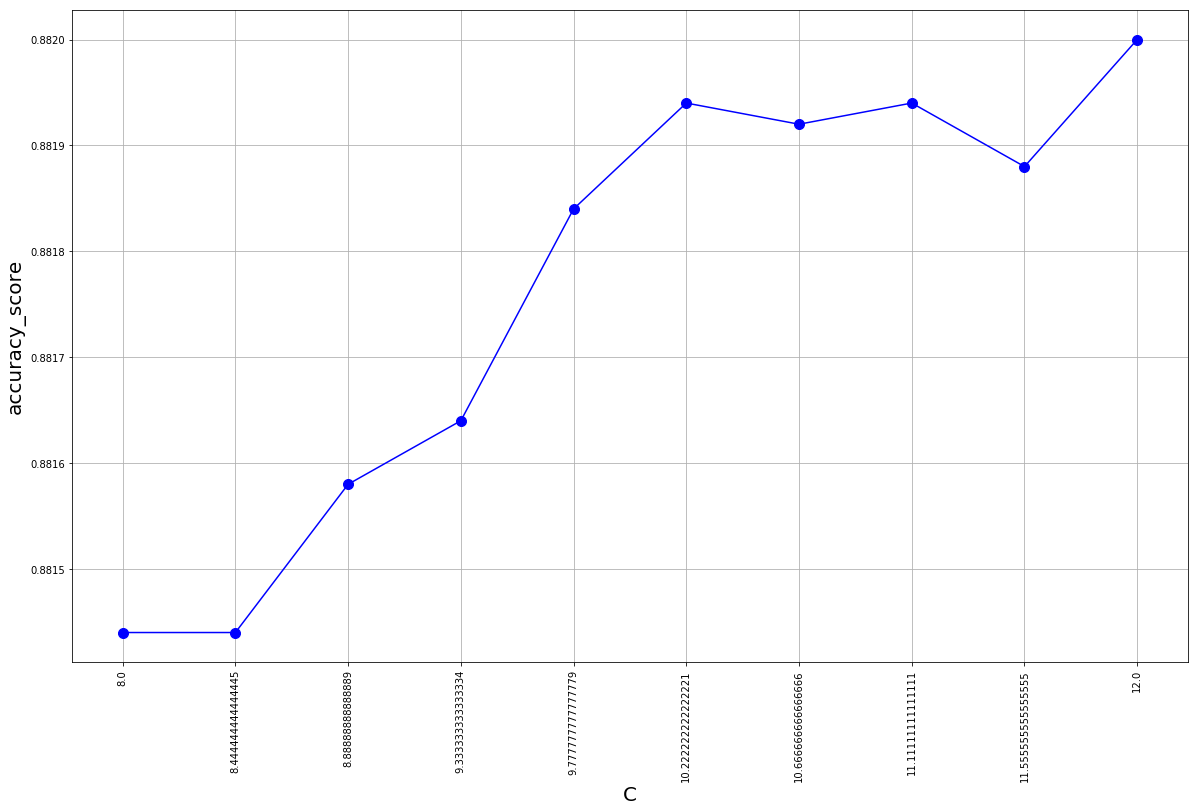

In [23]:
plot_accuracy(np.linspace(8, 12, 10), 'clf_logr_{}', y_test, X_test_tf_idf)

## XGBClassifier fitting

In [2]:
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
import multiprocessing
from sklearn.pipeline import Pipeline
import xgboost as xgb 
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from nltk.stem.snowball import SnowballStemmer
import string

stopWords = stopwords.words('russian')
stemmer = SnowballStemmer("russian")

     |████████████████████████████████| 142.8MB 981kB/s eta 0:00:01   |█▊                              | 7.6MB 783kB/s eta 0:02:53     |██▍                             | 10.7MB 665kB/s eta 0:03:19     |█████                           | 22.5MB 631kB/s eta 0:03:11     |█████▉                          | 26.2MB 669kB/s eta 0:02:55     |██████                          | 26.4MB 1.1MB/s eta 0:01:46     |████████                        | 35.2MB 403kB/s eta 0:04:27     |████████                        | 35.4MB 544kB/s eta 0:03:18     |████████▏                       | 36.3MB 466kB/s eta 0:03:49     |████████▉                       | 39.4MB 690kB/s eta 0:02:30     |███████████▎                    | 50.3MB 254kB/s eta 0:06:05     |███████████▊                    | 52.2MB 208kB/s eta 0:07:16     |███████████▉                    | 53.0MB 361kB/s eta 0:04:09     |█████████████                   | 58.2MB 1.1MB/s eta 0:01:17     |███████████████▋                | 69.7MB 296kB/s eta 0:04:08     |██████

In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
#     s = [stemmer.stem(word) for word in s] #очень долго
    return s

In [ ]:
class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer(stop_words=stopWords,  min_df=4, max_df=0.8)
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [ ]:
# заново запускать очень долго)

# tfidf_transformer = Text2TfIdfTransformer()
# tfidf_transformer.fit(Train['title&description'])

In [ ]:
# tfidf_X_train = tfidf_transformer.transform(Train['title&description'])
# tfidf_X_test = tfidf_transformer.transform(Test['title&description'])

In [ ]:
# tfidf_X_train.shape

In [ ]:
# gc.collect()
# clf = xgb.XGBClassifier(n_estimators=100, n_jobs=32, objective='multi:softmax', max_depth=8, min_child_weight=2)
# clf.fit(tfidf_X_train, Train['Category'])

## Final fit

In [24]:
tf_idf = TfidfVectorizer()
tf_idf.fit(Train['title&description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [26]:
Train_tf_idf = tf_idf.transform(Train['title&description'])
Test_tf_idf = tf_idf.transform(Test['title&description'])

In [27]:
clf = LogisticRegression(C=11.125, solver='sag', max_iter=500, n_jobs=64)
st = time.time()
clf.fit(Train_tf_idf, Train['Category'])
print(time.time() - st)

/home/ubuntu/python-virtual-environments/p3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1124.5449438095093


In [189]:
Answer = pd.DataFrame(columns=['Id', 'Category'])
Answer['Id'] = Test['itemid']

In [190]:
Answer['Category'] = clf.predict(Test_tf_idf)
Answer.to_csv('my_submission_logreg.csv', index=None)